# Pipeline of the anomaly detection on the SKAB using Hotelling's $T^2$ statistic

Details regarding the SKAB one can find in the [SKAB repository](https://github.com/waico/SKAB).

## Libraries importing

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# additional modules
import sys
sys.path.append('../')
from ControlCharts import T2

## Data

Put the `data` folder from the SKAB repository in the root of this repository. So the path will be following: `../data/`. Or select your own path.

In [ ]:
path_to_data = '../data/'

### Data loading

In [2]:
# benchmark files checking
all_files=[]
import os
for root, dirs, files in os.walk(path_to_data):
    for file in files:
        if file.endswith(".csv"):
             all_files.append(os.path.join(root, file))

In [3]:
# datasets with anomalies loading
list_of_df = [pd.read_csv(file, 
                          sep=';', 
                          index_col='datetime', 
                          parse_dates=True) for file in all_files if 'anomaly-free' not in file]
# anomaly-free df loading
anomaly_free_df = pd.read_csv([file for file in all_files if 'anomaly-free' in file][0], 
                            sep=';', 
                            index_col='datetime', 
                            parse_dates=True)

### Data description

In [16]:
# dataset characteristics printing
print('SKAB v0.9')
print(f'- A number of datasets: {len(list_of_df)}')
print(f'- Shape of the random dataset: {list_of_df[10].shape}')
n_cp = sum([len(df[df.changepoint==1.]) for df in list_of_df])
n_outlier = sum([len(df[df.anomaly==1.]) for df in list_of_df])
print(f'- A number of changepoints: {n_cp}')
print(f'- A number of outliers (point anomalies): {n_outlier}\n')
print(f'Head of the random dataset:')
display(list_of_df[0].head(1))

SKAB v0.9
- A number of datasets: 34
- Shape of the random dataset: (1146, 10)
- A number of changepoints: 129
- A number of outliers (point anomalies): 13067

Head of the random dataset:


,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS,anomaly,changepoint
datetime,,,,,,,,,,
2020-03-09 12:14:36,0.027429,0.040353,0.77031,0.382638,71.2129,25.0827,219.789,32.0,0.0,0.0


### Data visualization

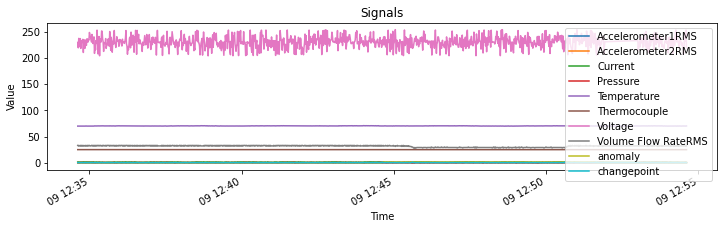

In [5]:
# random dataset visualizing
list_of_df[1].plot(figsize=(12, 3))
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Signals')
plt.show()

### Labels visualization

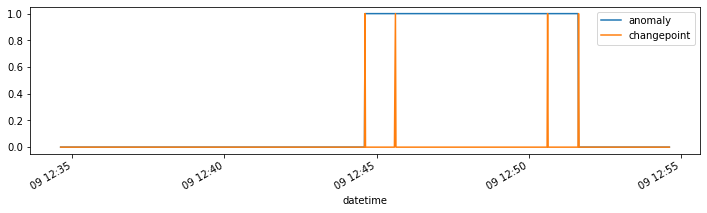

In [6]:
# plotting the labels both for outlier and changepoint detection problems
list_of_df[1].anomaly.plot(figsize=(12, 3))
list_of_df[1].changepoint.plot()
plt.legend()
plt.show()

## Method

### Method initialization

In [7]:
# classifier initializing
t2 = T2(scaling=True, using_pca=False)

### Method fitting and applying

In [8]:
# inference
predicted_outlier, predicted_cp = [], []
for df in list_of_df:
    X_train = df[:400].drop(['anomaly', 'changepoint'], axis=1)
    
    # classifier fitting
    t2.fit(X_train)
    
    # results predicting
    t2.predict(df.drop(['anomaly', 'changepoint'], axis=1), 
               window_size=5, 
               plot_fig=False)
    prediction = pd.Series((t2.t2['T2'].values > (2 * t2.t2_ucl)).astype(int), 
                                index=df.index).fillna(0)
    # predicted outliers saving
    predicted_outlier.append(prediction)
    
    # predicted CPs saving
    prediction_cp = abs(prediction.diff())
    prediction_cp[0] = prediction[0]
    predicted_cp.append(prediction_cp)

### Results visualization

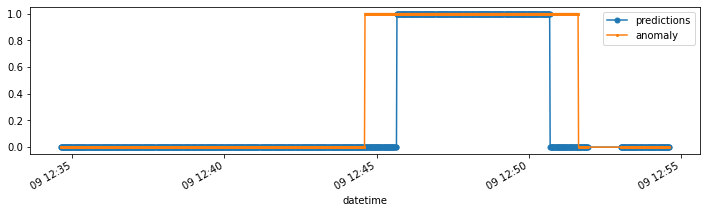

In [9]:
# true outlier indices selection
true_outlier = [df.anomaly for df in list_of_df]

predicted_outlier[1].plot(figsize=(12,3), label='predictions', marker='o', markersize=5)
true_outlier[1].plot(marker='o', markersize=2)
plt.legend();

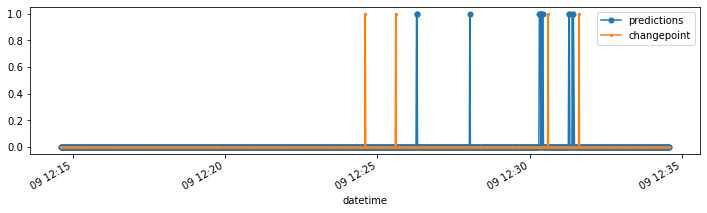

In [10]:
# true changepoint indices selection
true_cp = [df.changepoint for df in list_of_df]

predicted_cp[0].plot(figsize=(12,3), label='predictions', marker='o', markersize=5)
true_cp[0].plot(marker='o', markersize=2)
plt.legend();

## Evaluation (metrics calculation)

In [11]:
# 'pip install tsad' if needed
from tsad.evaluating.evaluating import evaluating

### Binary classification (outlier detection) metrics

In [12]:
# binary classification metrics calculation
binary = evaluating(
    true_outlier, 
    predicted_outlier, 
    metric='binary'
)

Since you not choose numenta_time and portion, then portion will be 0.1
False Alarm Rate 8.71 %
Missing Alarm Rate 43.9 %
F1 metric 0.65


### Changepoint detection metrics

In [13]:
# average detection delay metric calculation
add = evaluating(
    true_cp, 
    predicted_cp, 
    metric='average_time'
)

Since you not choose numenta_time and portion, then portion will be 0.1
Intersection of scoring windows(Timestamp('2020-02-08 19:26:28'), Timestamp('2020-02-08 19:26:13.225000'))
Intersection of scoring windows(Timestamp('2020-02-08 18:20:42'), Timestamp('2020-02-08 18:20:20.920000'))
Intersection of scoring windows(Timestamp('2020-02-08 18:51:37'), Timestamp('2020-02-08 18:51:30.940000'))
Intersection of scoring windows(Timestamp('2020-02-08 17:17:12'), Timestamp('2020-02-08 17:16:48.960000'))
Intersection of scoring windows(Timestamp('2020-02-08 17:24:11'), Timestamp('2020-02-08 17:23:49.960000'))
Amount of true anomalies 129
A number of missed CPs = 117
A number of FPs = 272
Average time 0 days 00:00:12.166666666


In [14]:
# nab metric calculation
nab = evaluating(
    true_cp, 
    predicted_cp, 
    metric='nab'
)

Since you not choose numenta_time and portion, then portion will be 0.1
Intersection of scoring windows(Timestamp('2020-02-08 19:26:28'), Timestamp('2020-02-08 19:26:13.225000'))
Intersection of scoring windows(Timestamp('2020-02-08 18:20:42'), Timestamp('2020-02-08 18:20:20.920000'))
Intersection of scoring windows(Timestamp('2020-02-08 18:51:37'), Timestamp('2020-02-08 18:51:30.940000'))
Intersection of scoring windows(Timestamp('2020-02-08 17:17:12'), Timestamp('2020-02-08 17:16:48.960000'))
Intersection of scoring windows(Timestamp('2020-02-08 17:24:11'), Timestamp('2020-02-08 17:23:49.960000'))
Standart  -  -4.82
LowFP  -  -16.66
LowFN  -  -0.11
